In [1]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
import textstat
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from textstat.textstat import textstat
from matplotlib.table import Table
from scipy.stats import multivariate_normal, invwishart
from abc import ABC, abstractmethod
%matplotlib inline

In [2]:
df = pd.read_csv('main_dataset_train.csv')
test_df = pd.read_csv('exp_test.csv')

In [3]:
df

,index,author,text,ai_label
0,1,John Nery,The success of the Marcos-Duterte electoral al...,0
1,2,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,0
2,3,John Nery,One of many lessons from the ongoing Twitter f...,0
3,4,John Nery,Of course we all need to be particular about t...,0
4,5,John Nery,"In 'Some People Need Killing,' the acclaimed j...",0
5,6,Iris Gonzales,"Inside Bangladesh, it’s called the Gen Z revol...",0
6,7,Iris Gonzales,Curtains close. Kisses stop. Love stories end....,0
7,8,Iris Gonzales,The Marcos administration can’t pop the champa...,0
8,9,Iris Gonzales,"My late grandfather Jorge A. Gonzales, an outs...",0
9,10,Iris Gonzales,It’s a day celebrated not just in Japan but in...,0


In [4]:
#test_df

In [5]:
def preprocess_text(text):
    # Convert to lowercase
    return text.lower()

# Helper function to calculate complex sentence ratio
def count_clauses(sentence):
    # A simple approximation using commas, semicolons, and conjunctions
    return sentence.count(',') + sentence.count(';') + sentence.lower().count('and') + sentence.lower().count('but')

# Feature extraction function
def extract_features(text):
    # Tokenize words and sentences
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    # Basic metrics
    word_count = len([word for word in words if word.isalpha()])
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if len(sentences) > 0 else 0

    # Punctuation metrics
    punctuation_count = sum(1 for char in text if char in ['.', ',', ':', ';', '?', '!', '-', '\'', '\"'])
    punctuation_ratio = punctuation_count / word_count if word_count > 0 else 0
    avg_punctuation_per_sentence = punctuation_count / len(sentences) if len(sentences) > 0 else 0

    # Linguistic diversity features
    vocab_size = len(set([word for word in words if word.isalpha()]))
    vocab_ratio = vocab_size / word_count if word_count > 0 else 0

    # Readability metrics
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    smog_index = textstat.smog_index(text)
    cl_index = textstat.coleman_liau_index(text)

    # Sentence complexity metrics
    total_clauses = sum(count_clauses(sentence) for sentence in sentences)
    avg_clauses_per_sentence = total_clauses / len(sentences) if len(sentences) > 0 else 0
    complex_sentence_ratio = sum(1 for sentence in sentences if count_clauses(sentence) > 1) / len(sentences) if len(sentences) > 0 else 0

    # Lexical density
    pos_tags = pos_tag(words)
    content_words = [word for word, pos in pos_tags if pos.startswith(('NN', 'VB', 'JJ', 'RB'))]
    lexical_density = len(content_words) / word_count if word_count > 0 else 0

    return {
        'word_count': word_count,
        'sentence_count': len(sentences),
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_count': punctuation_count,
        'punctuation_ratio': punctuation_ratio,
        'avg_punctuation_per_sentence': avg_punctuation_per_sentence,
        'vocab_size': vocab_size,
        'vocab_ratio': vocab_ratio,
        'flesch_reading_ease': flesch_reading_ease,
        'gunning_fog': gunning_fog,
        'smog_index': smog_index,
        'coleman_liau_index': cl_index,
        'avg_clauses_per_sentence': avg_clauses_per_sentence,
        'complex_sentence_ratio': complex_sentence_ratio,
        'lexical_density': lexical_density
    }

# Apply preprocessing and feature extraction to each text sample
def preprocess_and_extract_features(df):
    df['preprocessed_text'] = df['text'].apply(preprocess_text)
    df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
    return pd.concat([df[['index', 'label']], df_features], axis=1)

In [6]:
#Apply preprocessing and feature extraction to each text sample
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

In [7]:
# Model training
X = df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
y = df['author']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

In [8]:
# Model Preparation
X_test = test_df.drop(['index', 'label'], axis=1)
y_test = test_df['label']

In [9]:
def classify_new_text(new_text, model):
    # Preprocess the text and extract features
    preprocessed_text = preprocess_text(new_text)
    new_features = extract_features(preprocessed_text)
    new_features_df = pd.DataFrame([new_features])

    # Reindex using the cleaned X_train's columns
    new_features_df = new_features_df.reindex(columns=X_train.columns)

    # Handle any NaN values
    new_features_df = new_features_df.fillna(0)

    # Predict the author
    predicted_author = model.predict(new_features_df)
    return predicted_author[0]

In [10]:
# Function to extract features and store them into a DataFrame
def extract_features_as_df(text):
    # Call the existing extract_features function
    raw_features = extract_features(text)
    
    # Convert the features to a DataFrame with two columns: Feature and Value
    features_df = pd.DataFrame(list(raw_features.items()), columns=['Feature', 'Value'])
    
    return features_df

def extract_features_for_csv(df):
    feature_dfs = df['text'].apply(extract_features_as_df)
    
    # Concatenate all the feature DataFrames into a single DataFrame
    all_features = pd.concat(feature_dfs.tolist(), ignore_index=True)
    
    # Concatenate the extracted features with the original DataFrame
    df_features = pd.concat([df, all_features], axis=1)
    
    # Remove rows with any NaN values
    df_features_cleaned = df_features.dropna()
    
    return df_features_cleaned

df_features = extract_features_for_csv(df)
df_features

,index,author,text,ai_label,preprocessed_text,word_count,sentence_count,avg_word_length,avg_sentence_length,punctuation_count,...,vocab_ratio,flesch_reading_ease,gunning_fog,smog_index,coleman_liau_index,avg_clauses_per_sentence,complex_sentence_ratio,lexical_density,Feature,Value
0,1.0,John Nery,The success of the Marcos-Duterte electoral al...,0.0,the success of the marcos-duterte electoral al...,1558.0,65.0,4.835045,23.969231,179.0,...,0.391528,47.32,13.13,13.8,11.78,2.000000,0.523077,0.620668,word_count,1558.000000
1,2.0,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,0.0,the war on ninoy aquino’s legacy is a fight th...,1475.0,56.0,4.792542,26.339286,174.0,...,0.395932,54.66,13.13,13.4,11.09,2.589286,0.625000,0.608136,sentence_count,68.000000
2,3.0,John Nery,One of many lessons from the ongoing Twitter f...,0.0,one of many lessons from the ongoing twitter f...,851.0,39.0,4.659224,21.820513,117.0,...,0.453584,67.28,11.03,11.1,10.21,2.256410,0.487179,0.642773,avg_word_length,4.835045
3,4.0,John Nery,Of course we all need to be particular about t...,0.0,of course we all need to be particular about t...,996.0,40.0,4.618474,24.900000,109.0,...,0.391566,57.20,12.12,13.1,10.51,2.175000,0.600000,0.648594,avg_sentence_length,22.911765
4,5.0,John Nery,"In 'Some People Need Killing,' the acclaimed j...",0.0,"in 'some people need killing,' the acclaimed j...",1800.0,73.0,4.695000,24.657534,274.0,...,0.402222,59.53,11.04,11.8,10.68,2.808219,0.561644,0.655000,punctuation_count,179.000000
5,6.0,Iris Gonzales,"Inside Bangladesh, it’s called the Gen Z revol...",0.0,"inside bangladesh, it’s called the gen z revol...",892.0,40.0,4.936099,22.300000,108.0,...,0.470852,60.14,11.23,12.7,11.78,2.175000,0.525000,0.656951,punctuation_ratio,0.114891
6,7.0,Iris Gonzales,Curtains close. Kisses stop. Love stories end....,0.0,curtains close. kisses stop. love stories end....,918.0,46.0,4.578431,19.956522,122.0,...,0.430283,69.41,10.18,10.9,9.52,2.326087,0.652174,0.604575,avg_punctuation_per_sentence,2.632353
7,8.0,Iris Gonzales,The Marcos administration can’t pop the champa...,0.0,the marcos administration can’t pop the champa...,1774.0,80.0,5.050733,22.175000,190.0,...,0.224352,52.49,9.69,12.9,12.47,1.650000,0.400000,0.658399,vocab_size,644.000000
8,9.0,Iris Gonzales,"My late grandfather Jorge A. Gonzales, an outs...",0.0,"my late grandfather jorge a. gonzales, an outs...",879.0,46.0,4.982935,19.108696,106.0,...,0.465301,53.61,11.37,12.3,11.77,1.869565,0.500000,0.630262,vocab_ratio,0.413350
9,10.0,Iris Gonzales,It’s a day celebrated not just in Japan but in...,0.0,it’s a day celebrated not just in japan but in...,895.0,31.0,5.010056,28.870968,106.0,...,0.490503,44.48,14.84,14.7,12.77,3.258065,0.677419,0.658101,flesch_reading_ease,47.320000


In [11]:
# Feature normalization ranges
feature_ranges = {
    'word_count': (0, 10000),  # Adjust as needed
    'sentence_count': (0, 1000),  # Adjust as needed
    'avg_word_length': (1, 10),  # Average word length typically ranges from 1 to 10 characters
    'avg_sentence_length': (0, 100),  # Average sentence length in words
    'punctuation_count': (0, 1000),  # Total punctuation marks, adjust as needed
    'punctuation_ratio': (0, 1),  # Ratio of punctuation marks per character
    'avg_punctuation_per_sentence': (0, 10),  # Adjust based on expected punctuation per sentence
    'vocab_size': (0, 1000),  # Vocabulary size, adjust as needed
    'vocab_ratio': (0, 1),  # Vocabulary ratio
    'flesch_reading_ease': (0, 100),  # Flesch reading ease score
    'gunning_fog': (6, 17),  # Gunning-Fog Index
    'smog_index': (6, 17),  # SMOG Index
    'coleman_liau_index': (5, 17),  # Coleman-Liau Index
    'avg_clauses_per_sentence': (0, 10),  # Average number of clauses per sentence
    'complex_sentence_ratio': (0, 1),  # Ratio of complex sentences
    'lexical_density': (0, 1)  # Lexical density
}

def normalize_feature(value, feature_name, feature_ranges):
    """Normalize a single feature value based on its predefined range."""
    if feature_name in feature_ranges:
        min_val, max_val = feature_ranges[feature_name]
        if max_val - min_val == 0:  # Avoid division by zero
            return 0
        return (value - min_val) / (max_val - min_val)
    else:
        raise ValueError(f"Feature '{feature_name}' does not have defined normalization ranges.")

def extract_and_normalize_features_as_df(text, feature_ranges):
    """Extract features, normalize them, and return as a DataFrame with normalized columns."""
    # Extract features into a DataFrame
    features_df = extract_features_as_df(text)

    # Check for empty or missing data
    if features_df.empty:
        print("No features extracted for the text. Returning an empty DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame for consistency

    # Create a dictionary to store normalized values
    normalized_data = {}

    for _, row in features_df.iterrows():
        feature_name = row['Feature']
        raw_value = row['Value']

        if feature_name in feature_ranges:
            # Normalize the feature value and add it as a new column
            normalized_data[f"{feature_name}_normalized"] = normalize_feature(raw_value, feature_name, feature_ranges)
        else:
            print(f"Feature '{feature_name}' not found in feature_ranges. Skipping normalization.")

    # Convert normalized data to a DataFrame
    normalized_df = pd.DataFrame([normalized_data])
    return normalized_df

def extract_and_normalize_features_for_csv(df, feature_ranges):
    """Extract and normalize features for the entire dataset."""
    # Initialize a list to store normalized DataFrames for each text
    normalized_dfs = []

    for text in df['text']:
        normalized_df = extract_and_normalize_features_as_df(text, feature_ranges)
        normalized_dfs.append(normalized_df)

    # Concatenate all normalized DataFrames into a single DataFrame
    all_normalized_features = pd.concat(normalized_dfs, ignore_index=True)

    # Add the normalized columns to the original DataFrame
    df_features = pd.concat([df.reset_index(drop=True), all_normalized_features.reset_index(drop=True)], axis=1)

    # Drop rows with NaN values if any normalized feature is missing
    df_features_cleaned = df_features.dropna()

    return df_features_cleaned

In [12]:
# Extract and normalize features for the dataset
df_normalized_features = extract_and_normalize_features_for_csv(df, feature_ranges)

# Display the normalized DataFrame
df_normalized_features

,index,author,text,ai_label,preprocessed_text,word_count,sentence_count,avg_word_length,avg_sentence_length,punctuation_count,...,avg_punctuation_per_sentence_normalized,vocab_size_normalized,vocab_ratio_normalized,flesch_reading_ease_normalized,gunning_fog_normalized,smog_index_normalized,coleman_liau_index_normalized,avg_clauses_per_sentence_normalized,complex_sentence_ratio_normalized,lexical_density_normalized
0,1,John Nery,The success of the Marcos-Duterte electoral al...,0,the success of the marcos-duterte electoral al...,1558.0,65.0,4.835045,23.969231,179.0,...,0.263235,0.644,0.413350,0.4732,0.648182,0.709091,0.565000,0.191176,0.529412,0.616816
1,2,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,0,the war on ninoy aquino’s legacy is a fight th...,1475.0,56.0,4.792542,26.339286,174.0,...,0.310714,0.615,0.416949,0.5466,0.648182,0.672727,0.507500,0.258929,0.625000,0.604746
2,3,John Nery,One of many lessons from the ongoing Twitter f...,0,one of many lessons from the ongoing twitter f...,851.0,39.0,4.659224,21.820513,117.0,...,0.292500,0.409,0.480611,0.6728,0.457273,0.463636,0.434167,0.220000,0.475000,0.643948
3,4,John Nery,Of course we all need to be particular about t...,0,of course we all need to be particular about t...,996.0,40.0,4.618474,24.900000,109.0,...,0.272500,0.412,0.413655,0.5720,0.556364,0.645455,0.459167,0.217500,0.600000,0.649598
4,5,John Nery,"In 'Some People Need Killing,' the acclaimed j...",0,"in 'some people need killing,' the acclaimed j...",1800.0,73.0,4.695000,24.657534,274.0,...,0.375342,0.769,0.427222,0.5953,0.458182,0.527273,0.473333,0.280822,0.561644,0.653889
5,6,Iris Gonzales,"Inside Bangladesh, it’s called the Gen Z revol...",0,"inside bangladesh, it’s called the gen z revol...",892.0,40.0,4.936099,22.300000,108.0,...,0.251163,0.443,0.496081,0.6014,0.475455,0.609091,0.565000,0.202326,0.511628,0.658455
6,7,Iris Gonzales,Curtains close. Kisses stop. Love stories end....,0,curtains close. kisses stop. love stories end....,918.0,46.0,4.578431,19.956522,122.0,...,0.265217,0.422,0.459695,0.6941,0.380000,0.445455,0.376667,0.232609,0.652174,0.596950
7,8,Iris Gonzales,The Marcos administration can’t pop the champa...,0,the marcos administration can’t pop the champa...,1774.0,80.0,5.050733,22.175000,190.0,...,0.226190,0.427,0.240699,0.5249,0.335455,0.627273,0.622500,0.157143,0.380952,0.659526
8,9,Iris Gonzales,"My late grandfather Jorge A. Gonzales, an outs...",0,"my late grandfather jorge a. gonzales, an outs...",879.0,46.0,4.982935,19.108696,106.0,...,0.225532,0.434,0.493743,0.5361,0.488182,0.572727,0.564167,0.182979,0.468085,0.632537
9,10,Iris Gonzales,It’s a day celebrated not just in Japan but in...,0,it’s a day celebrated not just in japan but in...,895.0,31.0,5.010056,28.870968,106.0,...,0.341935,0.466,0.520670,0.4448,0.803636,0.790909,0.647500,0.325806,0.677419,0.653631


In [13]:
# Function to extract stylometric features for BOCPD
def extract_stylometric_features_for_bocpd(new_text):
    preprocessed_text = preprocess_text(new_text)
    features = extract_features(preprocessed_text)
    return features

In [14]:
# Hazard function
def constant_hazard(lam, t):
    return 1 / lam

# Predictive model (Gaussian)
class MultivariateGaussianPredictiveModel:
    def __init__(self, mu0, kappa0=1, alpha0=1, beta0=None):
        # mu0 is a vector for the mean of the prior
        # beta0 is a matrix for the covariance of the prior
        self.mu0 = np.array(mu0)
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0 if beta0 is not None else np.eye(len(mu0))  # Identity matrix if not provided
        
        # Initialize posterior parameters
        self.mu = np.array(mu0)
        self.kappa = kappa0
        self.alpha = alpha0
        self.beta = np.array(self.beta0)

    def update(self, x):
        x = np.array(x)
        self.kappa += 1
        self.mu = (self.kappa * self.mu0 + x) / (self.kappa + 1)
        diff = x - self.mu0
        self.beta += 0.5 * np.outer(diff, diff)  # Update covariance
        self.alpha += 0.5

    def log_predictive(self, x):
        d = len(self.mu0)  # Dimensionality
        x = np.array(x)

        # Covariance matrix for predictive distribution
        cov_matrix = (self.beta * (self.kappa + 1)) / (self.alpha * self.kappa)
    
        # Regularize the covariance matrix
        cov_matrix += np.eye(d) * 1e-6  # Add small value to diagonal

        try:
            cov_det = np.linalg.det(cov_matrix)
            cov_inv = np.linalg.inv(cov_matrix)

            # Multivariate Gaussian log probability
            log_prob = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(cov_det) - \
                       0.5 * np.dot((x - self.mu).T, np.dot(cov_inv, (x - self.mu)))
            return log_prob
        except np.linalg.LinAlgError:
            print("Covariance matrix is singular. Returning -inf for log probability.")
            return -np.inf  # Return a very low log probability

# Bayesian Online Change Point Detection algorithm
def bocpd(data, hazard_func, predictive_model):
    T = len(data)
    P = np.zeros((T+1, T+1))
    P[0, 0] = 1
    
    max_run_length = []
    
    for t in range(1, T+1):
        hazard = hazard_func(t)
        log_pred_prob = np.array([predictive_model.log_predictive(data[t-1]) for _ in range(t)])
        P[t, 1:t+1] = P[t-1, :t] * np.exp(log_pred_prob) * (1 - hazard)
        P[t, 0] = np.sum(P[t-1, :t] * hazard)
        P[t, :t+1] /= np.sum(P[t, :t+1])
        predictive_model.update(data[t-1])
        max_run_length.append(np.argmax(P[t, :t+1]))
    
    return P, max_run_length

# Detect change points
def detect_change_points(run_length_probs):
    change_points = []
    for t, prob in enumerate(run_length_probs):
        if prob == 0:  # Run length resets, indicating a change
            change_points.append(t)
    return change_points


In [15]:
def display_table_with_white_background(dataframe, title):
    # Round numeric values to 2 decimal places
    dataframe = dataframe.round(2)

    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # This will set the default font size for the table

    # Set column width and cell height
    col_width = 1.5
    row_height = 0.4
    num_rows, num_cols = dataframe.shape

    # Add table headers
    for i, column in enumerate(dataframe.columns):
        cell = table.add_cell(0, i, width=col_width, height=row_height, text=column, loc='center', facecolor='white', edgecolor='black')
        cell._text.set_fontsize(12)  # Set font size for header

    # Add table data
    for i, row in dataframe.iterrows():
        for j, value in enumerate(row):
            cell = table.add_cell(i + 1, j, width=col_width, height=row_height, text=f"{value:.2f}" if isinstance(value, (int, float)) else value, loc='center', facecolor='white', edgecolor='black')
            cell._text.set_fontsize(10)  # Set font size for data

    ax.add_table(table)
    plt.title(title, fontsize=14, pad=20)
    plt.show()

In [16]:
def detect_change_points_in_text(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features = extract_features(preprocess_text(new_text))
    
    features_df = pd.DataFrame([features])
    features_df = features_df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
    
    predicted_author = trained_model.predict(features_df)

    print(f"Provided Author: {author}")
    print(f"Predicted Author: {predicted_author}")
    
    if predicted_author[0] != author:
        print(f"Warning: The provided author does not match the predicted author. Using provided author '{author}' for analysis. Predicted author is: '{predicted_author}'")
    
    # Extract stylometric features for each sentence
    sentences = sent_tokenize(new_text)
    sentence_features = []
    
    for sentence in sentences:
        preprocessed_sentence = preprocess_text(sentence)
        sentence_feature = extract_features(preprocessed_sentence)
        
        selected_features = [
            sentence_feature['avg_word_length'], 
            sentence_feature['avg_sentence_length'], 
            sentence_feature['punctuation_ratio'], 
            sentence_feature['vocab_ratio'],
            sentence_feature['flesch_reading_ease'],
            sentence_feature['gunning_fog'],
            sentence_feature['smog_index'],
            sentence_feature['coleman_liau_index'],
            sentence_feature['avg_clauses_per_sentence'],
            sentence_feature['complex_sentence_ratio'],
            sentence_feature['lexical_density']
        ]
        sentence_features.append(selected_features)
    
    sentence_features = np.array(sentence_features)
    
    # Initialize BOCPD model for multivariate data
    hazard_func = lambda t: constant_hazard(250, t)
    initial_mean = np.mean(sentence_features, axis=0)
    initial_covariance = np.cov(sentence_features, rowvar=False)  # Initial covariance matrix
    
    predictive_model = MultivariateGaussianPredictiveModel(mu0=initial_mean, beta0=initial_covariance)
    
    # Run BOCPD on all selected features (multivariate analysis)
    P, max_run_length = bocpd(sentence_features, hazard_func, predictive_model)

    # Detect change points
    changepoints = detect_change_points(max_run_length)

    feature_categories = {
        'Phraseology': ['avg_word_length', 'avg_sentence_length', 'avg_clauses_per_sentence'],
        'Punctuation': ['punctuation_ratio'],
        'Linguistic Diversity': ['vocab_ratio', 'lexical_density', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index', 'complex_sentence_ratio'],
        # 'readability': ['flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index'],
        # 'complexity': ['complex_sentence_ratio']
    }

    explanations = []
    changepoint_data = [] #List to collect data for DataFrame
    
    # Initialize counters for category changes
    category_changes = {category: set() for category in feature_categories.keys()}
    total_changes = {category: 0 for category in feature_categories.keys()}
    
    for idx in changepoints:
        if idx > 0 and idx < len(sentences):
            prev_features = sentence_features[idx - 1]
            curr_features = sentence_features[idx]
            
            feature_changes = []
            for i, feature_name in enumerate(
                ['avg_word_length', 'avg_sentence_length', 'punctuation_ratio', 'vocab_ratio',
                 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
                 'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']):
                
                change = curr_features[i] - prev_features[i]
                
                # Only include positive changes
                if change > 0:  # Process only non-zero changes
                    category = next((cat for cat, features in feature_categories.items() if feature_name in features), None)
    
                    if category:
                        category_changes[category].add(idx)
    
                        # Normalize change and ensure non-negative value
                        normalized_change = max(normalize_feature(change, feature_name, feature_ranges), 0)
    
                        feature_changes.append({
                            'Feature': feature_name,
                            'Change Value': normalized_change,  # Always non-negative
                            'Category': category
                        })
                        
                        # Add row to changepoint data
                        changepoint_data.append({
                            'Sentence Index': idx,
                            'Sentence': sentences[idx],
                            'Feature': feature_name,
                            'Change Value': normalized_change,
                            'Category': category
                        })
       
           
            if feature_changes:  # Only add explanations if there are valid positive changes
                explanation = {
                    'sentence': sentences[idx],
                    'feature_changes': feature_changes
                }
                explanations.append(explanation)

    # Create DataFrame from collected changepoint data
    changepoint_df = pd.DataFrame(changepoint_data)
    if not changepoint_df.empty:  # Check if the DataFrame is non-empty
        average_changes = (
            changepoint_df.groupby('Category')['Change Value']
            .mean()
            .reset_index()
            .rename(columns={'Change Value': 'Average Change Value'})
        )
        
        print("\n--- Average Normalized Change Value by Category ---")
        print(average_changes)
    else:
        print("No change points detected; no averages to calculate.") 

    # Summarize the average changes across all categories
    overall_mean = average_changes['Average Change Value'].sum() / 3  # Divide the sum by 3 categories
    print(f"\nOverall Mean of Change Values Across Categories: {overall_mean:.4f}")

    # Determine if the text is AI-generated based on the threshold
    if overall_mean > 0.20:
        print("The text is likely AI-generated.")
    if overall_mean <= 0.20:
        print("The text is likely human-written.")
    else:
        print("No change points detected; no averages to calculate.")
    
    # Display summary of changes by category
    # print("\n--- Percentage of Change by Category ---")
    # total_sentences = len(sentences)
    # for category, sentence_indices in category_changes.items():
    #     unique_changes = len(sentence_indices)
    #     category_percentage = (unique_changes / total_sentences) * 100 if total_sentences > 0 else 0
    #     print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")
    print("\n")
    # Display results similarly
    for explanation in explanations:
        print(f"Change detected in sentence: {explanation['sentence']}")
        print("Feature changes:")
        
        table_data = []
        for feature_change in explanation['feature_changes']:
            table_data.append([
                feature_change['Feature'],
                feature_change['Change Value'],
                feature_change['Category']
            ])
        
        change_table = pd.DataFrame(table_data, columns=[
            'Feature', 'Change Value', 'Category'
        ])
        display_table_with_white_background(change_table, "Change Point Detection of Features for this Sentence")

    # print("\n--- Percentage of Change by Category ---")
    # for category, changes in category_changes.items():
    #     total_sentences = len(sentences)
    #     category_percentage = (changes / total_sentences) * 100 if total_sentences > 0 else 0
    #     print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")

    return changepoints, explanations, changepoint_df


In [17]:
def detect_change_points_in_text_with_normalization(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features_df = extract_features_as_df(preprocess_text(new_text))
    
    # Normalize the feature values
    normalized_features_df = normalize_features(features_df)
    
    print("Features with Normalized Values:")
    display(normalized_features_df)
    
    # Use normalized values in further computations
    normalized_features = normalized_features_df['Normalized Value'].values
    
    # Perform changepoint detection using normalized features
    # (Insert the existing BOCPD changepoint detection logic here)
    # Ensure all calculations use the normalized_features array

    return normalized_features_df


Provided Author: Maria A. Ressa
Predicted Author: ['GPT4o-mini']

--- Average Normalized Change Value by Category ---
               Category  Average Change Value
0  Linguistic Diversity              0.186512
1           Phraseology              0.108215
2           Punctuation              0.070579

Overall Mean of Change Values Across Categories: 0.1218
The text is likely human-written.


Change detected in sentence: In the Philippines, this has taken the form of fake news campaigns, propaganda, and the weaponization of social media platforms to spread lies and manipulate public opinion.
Feature changes:


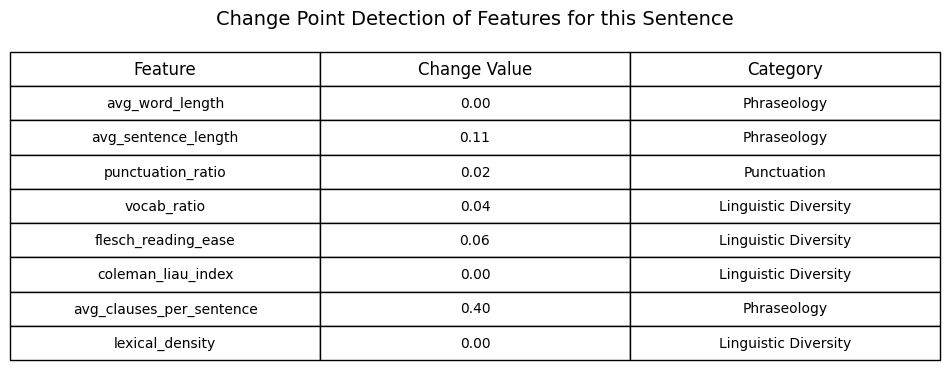

Change detected in sentence: Lies spread faster than facts, as algorithms prioritize engagement over truth, fueling outrage and division.
Feature changes:


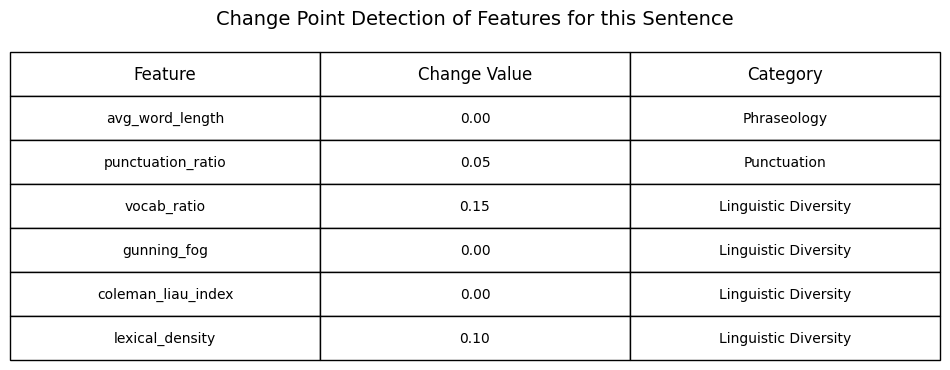

Change detected in sentence: Lessons from the Past: Disinformation and Authoritarianism

The Philippines has experienced firsthand how disinformation can rewrite history.
Feature changes:


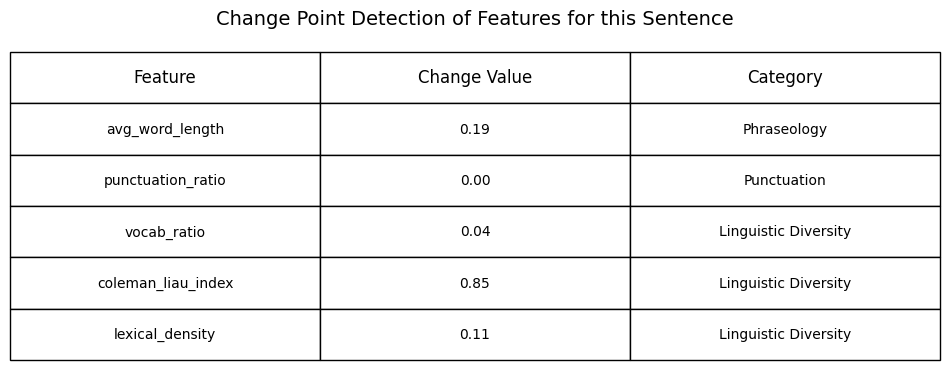

Change detected in sentence: Today, efforts to sanitize the legacy of Ferdinand Marcos Sr. and downplay the abuses of martial law are rampant online.
Feature changes:


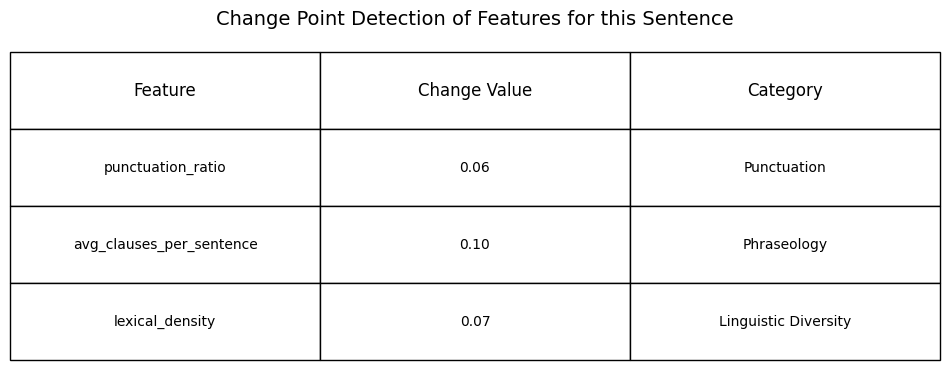

Change detected in sentence: These efforts have found fertile ground among younger Filipinos, many of whom lack access to accurate historical accounts in schools.
Feature changes:


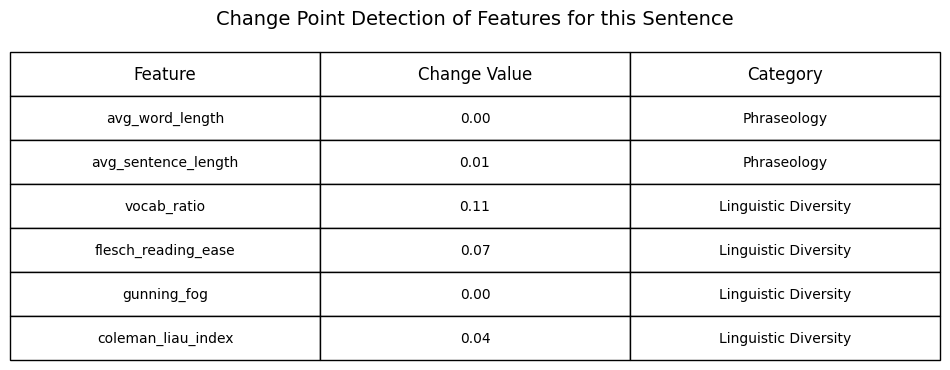

Change detected in sentence: By creating alternative realities, they seek to undermine accountability and perpetuate corruption.
Feature changes:


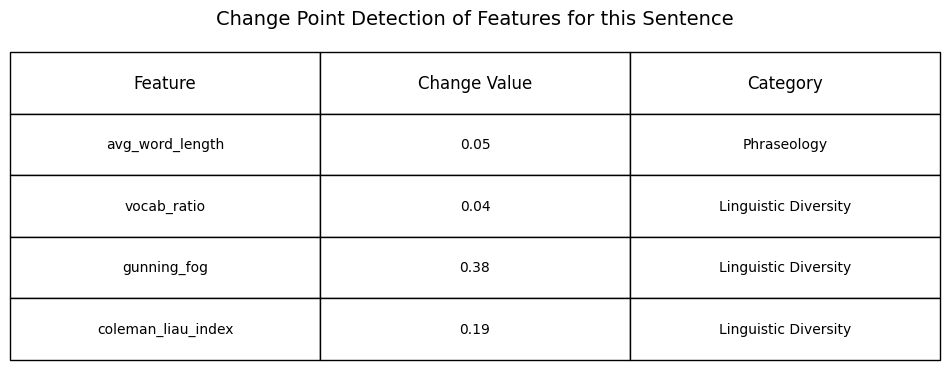

Change detected in sentence: Gen Z’s Awakening

Despite these challenges, Filipino Gen Z is proving to be a resilient and resourceful force.
Feature changes:


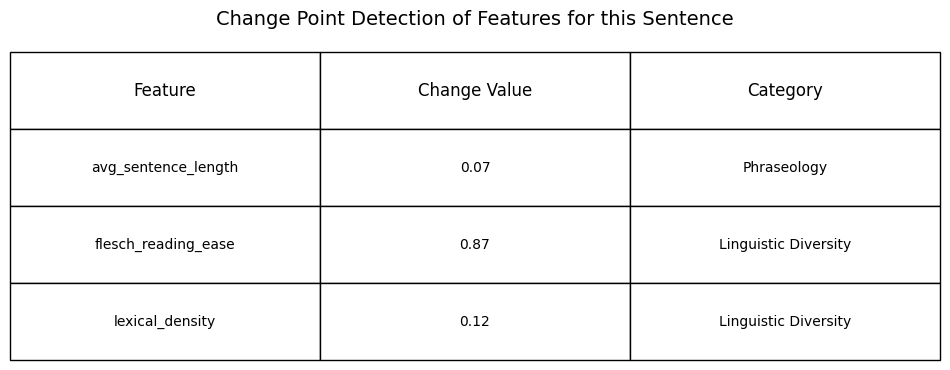

Change detected in sentence: Online campaigns, fact-checking initiatives, and grassroots movements have emerged, driven by a generation unwilling to accept the status quo.
Feature changes:


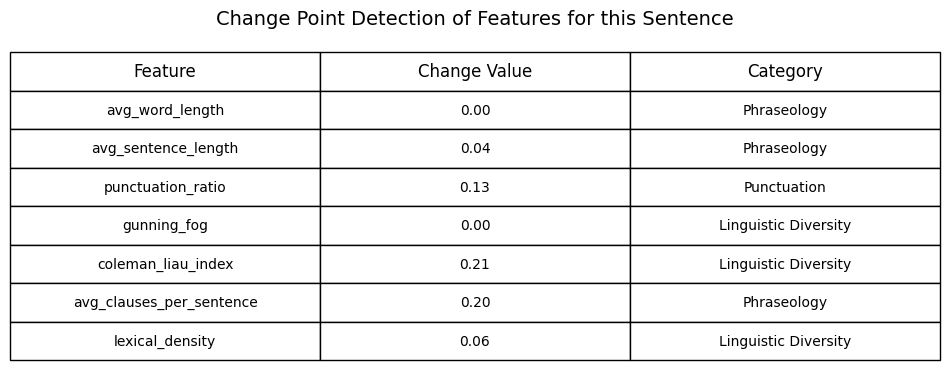

Change detected in sentence: For Gen Z, this is not just about resisting disinformation—it’s about redefining what it means to be Filipino in the 21st century.
Feature changes:


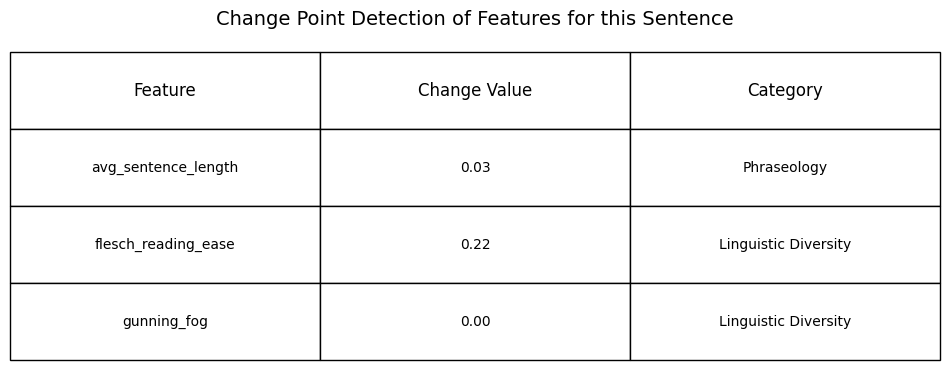

Change detected in sentence: They are taking to the streets and organizing online, demanding transparency, accountability, and a better future.
Feature changes:


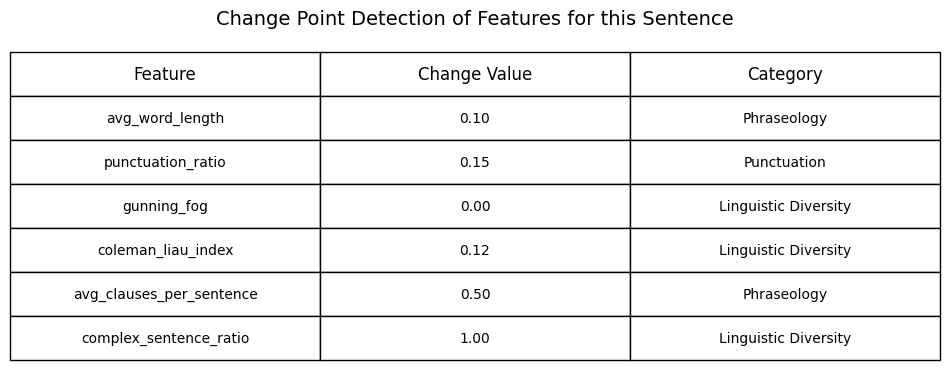

Change detected in sentence: The Fight for Accountability

As Shoshana Zuboff argues in her book "The Age of Surveillance Capitalism," the extractive business model of technology platforms is at the root of many of today’s challenges.
Feature changes:


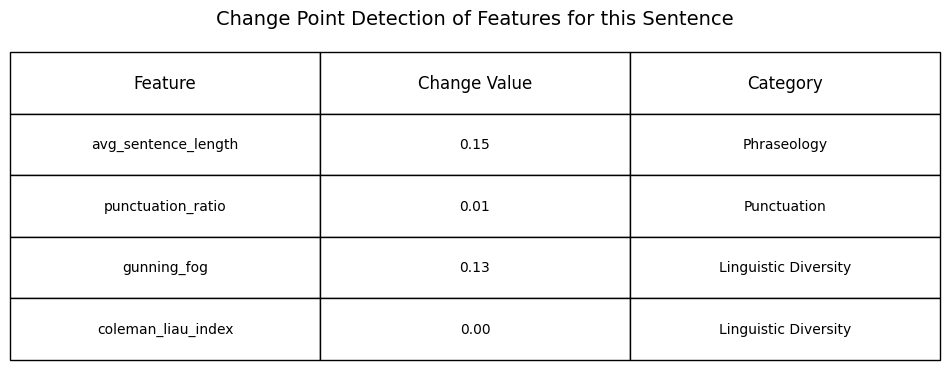

Change detected in sentence: But accountability doesn’t stop with technology companies.
Feature changes:


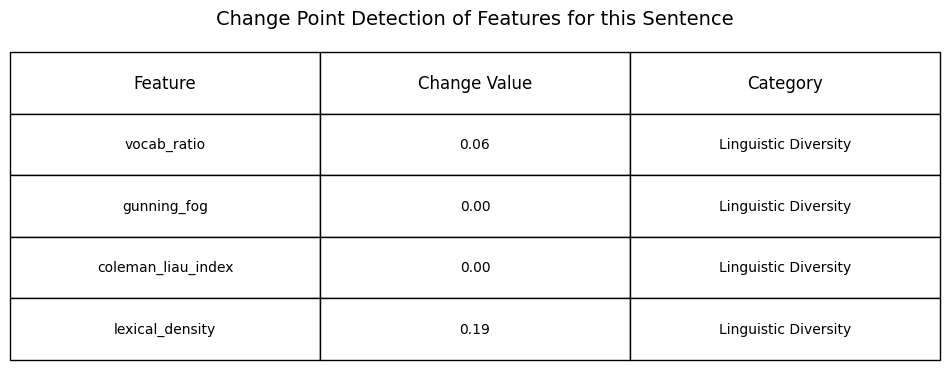

Change detected in sentence: The government must also step up.
Feature changes:


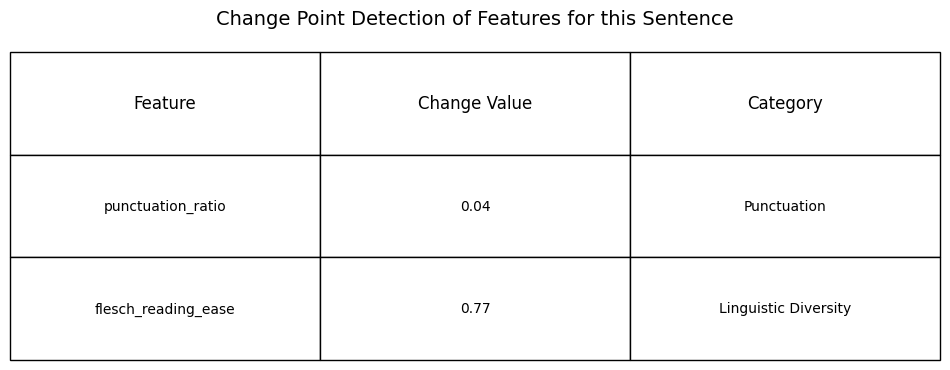

Change detected in sentence: Civic education must also emphasize the importance of participation in democratic processes.
Feature changes:


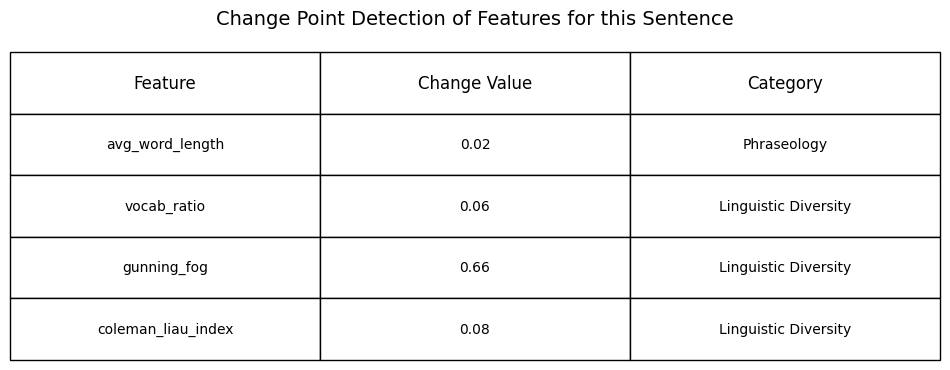

Change detected in sentence: They have the tools, the passion, and the numbers to drive meaningful change.
Feature changes:


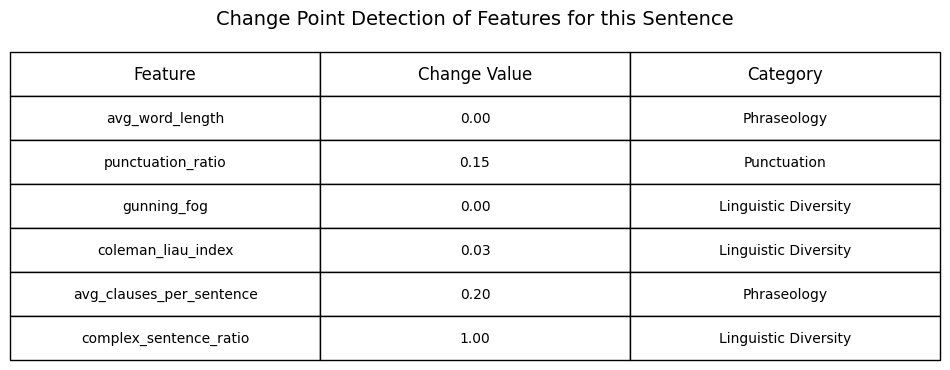


Changepoint Detection DataFrame:


,Sentence Index,Sentence,Feature,Change Value,Category
0,5,"In the Philippines, this has taken the form of...",avg_word_length,0.000000,Phraseology
1,5,"In the Philippines, this has taken the form of...",avg_sentence_length,0.110000,Phraseology
2,5,"In the Philippines, this has taken the form of...",punctuation_ratio,0.023148,Punctuation
3,5,"In the Philippines, this has taken the form of...",vocab_ratio,0.039352,Linguistic Diversity
4,5,"In the Philippines, this has taken the form of...",flesch_reading_ease,0.057500,Linguistic Diversity
...,...,...,...,...,...
66,39,"They have the tools, the passion, and the numb...",punctuation_ratio,0.153846,Punctuation
67,39,"They have the tools, the passion, and the numb...",gunning_fog,0.000000,Linguistic Diversity
68,39,"They have the tools, the passion, and the numb...",coleman_liau_index,0.028333,Linguistic Diversity
69,39,"They have the tools, the passion, and the numb...",avg_clauses_per_sentence,0.200000,Phraseology



--- Detailed Explanations of Changepoints ---
Change detected in sentence: In the Philippines, this has taken the form of fake news campaigns, propaganda, and the weaponization of social media platforms to spread lies and manipulate public opinion.
Feature changes:
  Feature: avg_word_length, Change Value: 0.0000, Category: Phraseology
  Feature: avg_sentence_length, Change Value: 0.1100, Category: Phraseology
  Feature: punctuation_ratio, Change Value: 0.0231, Category: Punctuation
  Feature: vocab_ratio, Change Value: 0.0394, Category: Linguistic Diversity
  Feature: flesch_reading_ease, Change Value: 0.0575, Category: Linguistic Diversity
  Feature: coleman_liau_index, Change Value: 0.0000, Category: Linguistic Diversity
  Feature: avg_clauses_per_sentence, Change Value: 0.4000, Category: Phraseology
  Feature: lexical_density, Change Value: 0.0046, Category: Linguistic Diversity

--------------------------------------------------------------------------------

Change detected in s

In [50]:
new_text = """Technology’s Grip on Democracy: How the Filipino Gen Z is Fighting Back

In the digital age, technology has become both a tool for empowerment and a weapon of manipulation. Across the globe, young people are grappling with its dual nature, navigating a world reshaped by social media, predictive analytics, and the rampant spread of disinformation. In the Philippines, Gen Z is at the forefront of a battle not only against corruption but also against the technological forces that threaten to undermine democracy itself.

The Double-Edged Sword of Technology

Technology has reshaped industries, from music and transportation to journalism and governance. But as much as it has democratized information, it has also become an enabler of disinformation. In the Philippines, this has taken the form of fake news campaigns, propaganda, and the weaponization of social media platforms to spread lies and manipulate public opinion. Lies spread faster than facts, as algorithms prioritize engagement over truth, fueling outrage and division.

This is not an abstract issue for Filipino Gen Z. They are living in a reality where social media feeds dictate their understanding of the world, creating filter bubbles and echo chambers. In a country with a long history of political propaganda, the rise of digital disinformation has only deepened societal divides and eroded trust in institutions. For a generation raised in the digital age, the challenge is clear: to reclaim technology as a force for good and to resist its darker impulses.

Lessons from the Past: Disinformation and Authoritarianism

The Philippines has experienced firsthand how disinformation can rewrite history. During the 2016 presidential election, the widespread use of troll farms and fake news played a crucial role in shaping public opinion. Today, efforts to sanitize the legacy of Ferdinand Marcos Sr. and downplay the abuses of martial law are rampant online. These efforts have found fertile ground among younger Filipinos, many of whom lack access to accurate historical accounts in schools.

The echoes of history are clear. Just as Russian propaganda used the "firehose of falsehood" to entertain, confuse, and overwhelm, similar tactics are now employed by political operators in the Philippines. By creating alternative realities, they seek to undermine accountability and perpetuate corruption.

Gen Z’s Awakening

Despite these challenges, Filipino Gen Z is proving to be a resilient and resourceful force. Armed with smartphones and social media savvy, they are using technology to push back. Online campaigns, fact-checking initiatives, and grassroots movements have emerged, driven by a generation unwilling to accept the status quo.

For Gen Z, this is not just about resisting disinformation—it’s about redefining what it means to be Filipino in the 21st century. They are taking to the streets and organizing online, demanding transparency, accountability, and a better future. In doing so, they are challenging not only corrupt systems but also the very platforms that enable disinformation.

The Fight for Accountability

As Shoshana Zuboff argues in her book "The Age of Surveillance Capitalism," the extractive business model of technology platforms is at the root of many of today’s challenges. In the Philippines, this has manifested in the manipulation of public opinion, the erosion of data privacy, and the undermining of democratic processes. To combat this, Filipino Gen Z must demand accountability from tech companies. This includes pushing for transparency in algorithms, better content moderation, and stronger protections for user data.

But accountability doesn’t stop with technology companies. The government must also step up. Laws such as the Freedom of Information (FOI) Act need to be fully implemented, and institutions tasked with fighting corruption must be strengthened and insulated from political interference. Without systemic reforms, the fight against disinformation and corruption will remain an uphill battle.

Rebuilding Trust Through Education

One of the most critical fronts in this battle is education. Schools must play a central role in equipping the youth with the tools to discern fact from fiction. Media literacy programs should be integrated into the curriculum, teaching students how to critically evaluate information and recognize disinformation tactics. Historical awareness is equally important, ensuring that the lessons of the past are not forgotten or rewritten.

Civic education must also emphasize the importance of participation in democratic processes. By fostering a sense of agency and responsibility, schools can empower students to become active participants in shaping their future.

A Call to Action

The Filipino Gen Z stands at a pivotal moment. They have the tools, the passion, and the numbers to drive meaningful change. But the challenges they face are immense. The fight against corruption, disinformation, and technological manipulation requires not only determination but also strategic action.

To succeed, they must focus on three key areas:

Demanding Accountability: From both technology companies and government institutions, ensuring that they serve the public interest and uphold democratic values.

Building Community: Strengthening ties among like-minded individuals and organizations to create a unified front against corruption and disinformation.

Investing in Education: Equipping the next generation with the knowledge and skills needed to navigate a complex and rapidly changing world.

The Road Ahead

Revolutions are never easy, and the forces of the status quo will not give up power without a fight. But history has shown that the collective will of the people, especially when led by the youth, can overcome even the most entrenched systems. The Filipino Gen Z has the potential to be the driving force behind a new era of accountability, transparency, and progress.

As the world watches, the question remains: will they rise to the challenge and seize the moment? The answer lies not just in their hands but in the collective resolve of a nation ready to fight for a brighter future."""
author = "Maria A. Ressa"
#thresholds = [0.5, 5, 0.02, 0.05, 5, 2, 1, 2]
# predicted_author = classify_new_text(new_text, clf)

# print(f"The predicted author is: {predicted_author}")
#changepoints, explanations = detect_change_points_in_text(new_text, author, clf)

# Detect changepoints, explanations, and changepoint DataFrame
changepoints, explanations, changepoint_df = detect_change_points_in_text(new_text, author, clf)

# Display options for pandas to prevent compression issues
pd.set_option('display.max_rows', 20)  # Show up to 20 rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust column width

# Display the changepoint DataFrame
print("\nChangepoint Detection DataFrame:")
display(changepoint_df)

# Display the same results as before using explanations
print("\n--- Detailed Explanations of Changepoints ---")
for explanation in explanations:
    print(f"Change detected in sentence: {explanation['sentence']}")
    print("Feature changes:")
    for feature_change in explanation['feature_changes']:
        print(f"  Feature: {feature_change['Feature']}, Change Value: {feature_change['Change Value']:.4f}, Category: {feature_change['Category']}")
    print("\n" + "-" * 80 + "\n")  # Add a separator line and a blank line